In [119]:
import pandas as pd
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from networkx.algorithms.community import modularity_max
from tabulate import tabulate
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
import csv
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from itertools import product
from sklearn.metrics.pairwise import euclidean_distances




In [120]:
!pip install xlsxwriter
!pip install geopandas
!pip install contextily

In [121]:
!pip install Cartopy
!pip install shapely matplotlib


In [122]:
df = pd.read_csv('Psittaciformes.csv')

In [123]:
basic_columns_list = [
    'scientificName',
    'familyName',
    'orderName',

    'Beak.Length_Culmen',
    'Beak.Length_Nares',
    'Beak.Width',
    'Beak.Depth',
    'Tarsus.Length',
    'Wing.Length',
    'Kipps.Distance',
    'Hand-Wing.Index',
    'Tail.Length',
    'Mass',

    'Habitat', 
    'Habitat.Density',
    'Migration',
    'Trophic.Level', 
    'Trophic.Niche', 
    'Primary.Lifestyle',
    
    'Min.Latitude',
    'Max.Latitude',
    'Centroid.Latitude',
    'Centroid.Longitude',
    'Range.Size',


    'redlistCategory',
    'populationTrend',

]

df = df[basic_columns_list]

In [124]:
Ecological_features = [ 
    'Habitat', 
    'Trophic.Level', 
    'Trophic.Niche', 
    'Primary.Lifestyle',
    'Habitat.Density',
    'Migration',
]

In [126]:
# Function to encode ecological features
def encoded_Ecological_features(df):
    categorical_columns = ['Habitat', 'Trophic.Level', 'Trophic.Niche', 'Primary.Lifestyle']
    
    # Apply one-hot encoding
    encoded_data = pd.get_dummies(df[categorical_columns], prefix=categorical_columns)

    # Add Habitat.Density and Migration (numerical column) to the encoded data
    encoded_data['Habitat.Density'] = df['Habitat.Density']
    encoded_data['Migration'] = df['Migration']
    
    # Add species_names to the encoded data
    encoded_data['species_names'] = df['scientificName'].values
    
    return encoded_data

In [127]:
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances

def calculate_similarity_matrix(encoded_data, weights):
    # Ecological features (grouped by categories)
    ecological_feature_groups = {
        'Habitat': ['Habitat_Desert', 'Habitat_Forest', 'Habitat_Grassland', 'Habitat_Human Modified', 'Habitat_Shrubland', 'Habitat_Woodland'],
        'Trophic.Level': ['Trophic.Level_Herbivore', 'Trophic.Level_Omnivore'],
        'Trophic.Niche': ['Trophic.Niche_Frugivore', 'Trophic.Niche_Granivore', 'Trophic.Niche_Herbivore terrestrial', 'Trophic.Niche_Nectarivore', 'Trophic.Niche_Omnivore'],
        'Primary.Lifestyle': ['Primary.Lifestyle_Generalist', 'Primary.Lifestyle_Insessorial', 'Primary.Lifestyle_Terrestrial'],
        'Habitat.Density': ['Habitat.Density'],
        'Migration': ['Migration']
    }
    
    # Initialize weighted_data as an empty list (to collect each group's weighted data)
    weighted_data_list = []

    # Apply weights for each group
    feature_idx = 0  # To track column index when adding the weighted data
    for group, columns in ecological_feature_groups.items():
        # Apply weight to each feature in this group
        weight = weights[feature_idx]
        group_data = encoded_data[columns].values
        weighted_group_data = group_data * weight
        
        # Append the weighted group data to the list
        weighted_data_list.append(weighted_group_data)
        
        feature_idx += 1

    # Convert the list of weighted group data into a single 2D array
    weighted_data = np.hstack(weighted_data_list)

    # Apply weights for numeric columns
    numeric_columns = ['Habitat.Density', 'Migration']
    for feature, weight in zip(numeric_columns, weights[feature_idx:]):
        numeric_data = encoded_data[feature].values.reshape(-1, 1)  # Reshape to column vector
        weighted_data = np.hstack([weighted_data, numeric_data * weight])

    # Now, calculate the similarity matrix
    distances = euclidean_distances(weighted_data)
    similarity_matrix = np.exp(-distances)  # Convert distances to similarities (exponential scaling)

    # Get species names
    species_names = encoded_data['species_names'].values
    
    return similarity_matrix, species_names


In [128]:
def create_knn_and_compute_modularity(similarity_matrix, species_names, df, k=5):
    """
    Create a KNN network and compute modularity in one function.
    
    Parameters:
        similarity_matrix: Matrix of pairwise species similarities
        species_names: List of species names
        df: DataFrame containing species attributes (latitude, longitude, family, etc.)
        k: Number of nearest neighbors to connect for each node
        
    Returns:
        G_knn: The generated KNN network
        modularity: The modularity score of the network
    """
    G_knn = nx.Graph()

    # Add nodes with attributes
    for species in species_names:
        # Get species data from DataFrame
        species_data_df = df[df['scientificName'] == species]
        
        if species_data_df.empty:
            print(f"Species {species} not found in the DataFrame. Skipping...")
            continue  # Skip this species if not found
        
        species_data = species_data_df.iloc[0]

        # Add node with relevant attributes
        G_knn.add_node(
            species,
            latitude=species_data['Centroid.Latitude'],
            longitude=species_data['Centroid.Longitude'],
            habitat=species_data['Habitat'],
            migration=species_data['Migration'],
            trophic_level=species_data['Trophic.Level'],
            trophic_niche=species_data['Trophic.Niche'],
            primary_lifestyle=species_data['Primary.Lifestyle'],
            family=species_data['familyName'],
            scientific_name=species
        )

    # Create a mask for the diagonal to exclude self-connections
    np.fill_diagonal(similarity_matrix, -np.inf)  # Set diagonal to negative infinity

    # Add edges based on k-nearest neighbors
    for i in range(len(species_names)):
        similarities = similarity_matrix[i]
        most_similar_indices = np.argsort(similarities)[::-1][:k]

        # Add edges to k nearest neighbors
        for j in most_similar_indices:
            G_knn.add_edge(
                species_names[i],
                species_names[j],
                weight=similarity_matrix[i][j]
            )

    # Compute modularity using community detection
    communities = list(nx.algorithms.community.greedy_modularity_communities(G_knn, weight='weight'))
    modularity = nx.algorithms.community.modularity(G_knn, communities, weight='weight')
    
    # Additional network statistics
    print(f"\nNetwork Statistics:")
    print(f"Number of nodes: {G_knn.number_of_nodes()}")
    print(f"Number of edges: {G_knn.number_of_edges()}")
    print(f"Average degree: {sum(dict(G_knn.degree()).values()) / G_knn.number_of_nodes():.2f}")
    print(f"Network density: {nx.density(G_knn):.4f}")
    
    return G_knn, modularity

In [129]:
def optimize_weights(df, weight_ranges, k=5, random_weights=None):
    """
    Optimize weights to maximize modularity.
    
    Parameters:
        - df: The dataframe containing species data.
        - weight_ranges: A list or range of possible weights for each feature.
        - k: Number of neighbors in the KNN graph.
        - random_weights: If provided, it overrides weight_ranges and uses these random weights instead.
        
    Returns:
        - best_weights: The best weights array found.
        - best_modularity: The highest modularity value achieved.
    """
    # Generate encoded data
    encoded_data = encoded_Ecological_features(df)  # You must have this function that returns encoded data

    # Determine weight combinations
    if random_weights is not None:
        # Use the provided random weights
        weight_combinations = random_weights
    else:
        # Generate all possible combinations of weights
        weight_combinations = product(*[weight_ranges] * 6)  # 6 weights: 4 for categorical, 2 for numeric

    best_modularity = -np.inf
    best_weights = None

    for weights in weight_combinations:
        # Convert weights to a NumPy array
        weights_array = np.array(weights)
        
        # Debug: Print the current weights being tested
        print(f"Testing weights: {weights_array}")
        
        # Calculate similarity matrix using the current weights
        similarity_matrix, species_names = calculate_similarity_matrix(encoded_data, weights_array)
        
        # Create KNN network and compute modularity
        _, modularity = create_knn_and_compute_modularity(similarity_matrix, species_names, df, k)
        
        # Update the best weights if modularity improves
        if modularity > best_modularity:
            best_modularity = modularity
            best_weights = weights_array
    
    return best_weights, best_modularity


In [130]:
# Visualize similarity distribution
def plot_similarity_distribution(similarity_matrix):
    """
    Plot the distribution of similarity values to help with thresholding
    """
    plt.figure(figsize=(10, 6))
    # Get upper triangle values
    upper_tri = similarity_matrix[np.triu_indices(len(similarity_matrix), k=1)]

    plt.hist(upper_tri, bins=50)
    plt.title('Distribution of Similarity Values')
    plt.xlabel('Similarity')
    plt.ylabel('count')


In [131]:
#Data Preparation
df_data = df.dropna(subset=Ecological_features).copy()

#Encode Catergorical Features into Binary Format
encoded_data = encoded_Ecological_features(df_data)


In [132]:
# Generate 500 random weight vectors (6 features, values between 0 and 1)
random_weights = [np.random.uniform(0, 1, 6) for _ in range(500)]

# Call the function with random weights
best_weights, best_modularity = optimize_weights(df_data, weight_ranges=None, k=5, random_weights=random_weights)

print(f"Best Weights: {best_weights}")
print(f"Best Modularity: {best_modularity}")


Testing weights: [0.24381793 0.91829405 0.81268901 0.59589362 0.23206616 0.09145959]

Network Statistics:
Number of nodes: 399
Number of edges: 1735
Average degree: 8.70
Network density: 0.0219
Testing weights: [0.51997733 0.52606457 0.53234028 0.43799274 0.31955681 0.69258297]

Network Statistics:
Number of nodes: 399
Number of edges: 1749
Average degree: 8.77
Network density: 0.0220
Testing weights: [0.66074352 0.19288166 0.86823073 0.1488135  0.33940868 0.81982729]

Network Statistics:
Number of nodes: 399
Number of edges: 1745
Average degree: 8.75
Network density: 0.0220
Testing weights: [0.29903344 0.56700162 0.58170078 0.9512301  0.73372126 0.02394857]

Network Statistics:
Number of nodes: 399
Number of edges: 1739
Average degree: 8.72
Network density: 0.0219
Testing weights: [0.85700024 0.80161196 0.24653282 0.0804726  0.24738249 0.09428339]

Network Statistics:
Number of nodes: 399
Number of edges: 1746
Average degree: 8.75
Network density: 0.0220
Testing weights: [0.94380588 0

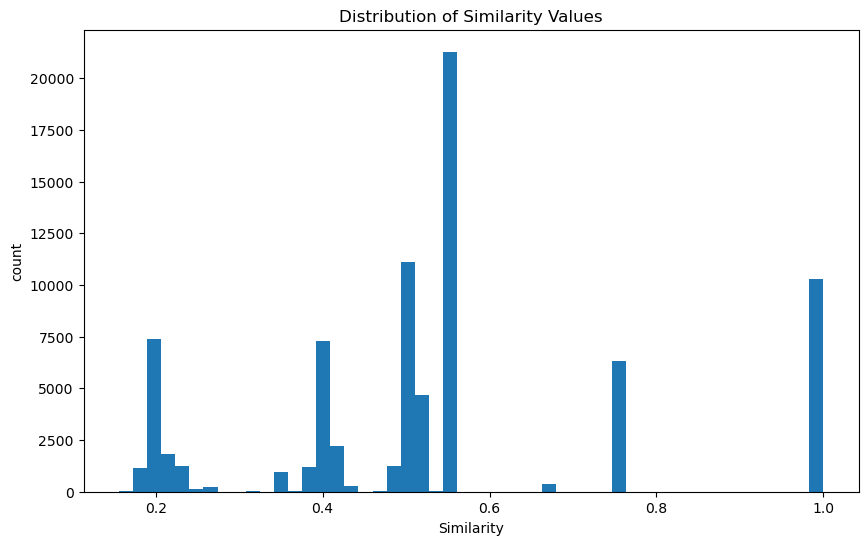

In [133]:
# Use the optimal weights to calculate the similarity matrix
optimal_weights = best_weights  
ecological_similarity_matrix, species_names = calculate_similarity_matrix(encoded_data, optimal_weights)

#distribution of similarity matrix
plot_similarity_distribution(ecological_similarity_matrix)

In [136]:
# Ensure that G_knn is the actual graph object
G_knn, modularity = create_knn_and_compute_modularity(ecological_similarity_matrix, species_names, df_data, k=5)



Network Statistics:
Number of nodes: 399
Number of edges: 1730
Average degree: 8.67
Network density: 0.0218


In [138]:
def visualize_and_save_knn_network(G_knn, output_filename="knn_network.gml", zoom_factor=1.5):
    """
    Visualizes the KNN network with a zoom effect and saves it as a GML file.
    
    Parameters:
        G_knn (networkx.Graph): The KNN graph to visualize.
        output_filename (str): The name of the output GML file. Defaults to "knn_network.gml".
        zoom_factor (float): A factor to zoom into the network. Default is 1.5.
    """
    # Set up a larger figure to make it zoomed in
    plt.figure(figsize=(12, 10))

    # Choose a layout for better visualization
    pos = nx.spring_layout(G_knn, k=zoom_factor, seed=42)  # Adjusting the spring layout for zoom effect

    # Draw the network
    nx.draw(G_knn, pos, with_labels=False, node_size=70, node_color="skyblue", font_size=12, font_weight="bold", edge_color="gray")

    # Set the title
    plt.title("Zoomed-in KNN Network Visualization", fontsize=16)

    # Display the plot
    plt.show()

    # Save the network to a GML file
    nx.write_gml(G_knn, output_filename)

    print(f"Network saved as {output_filename}")


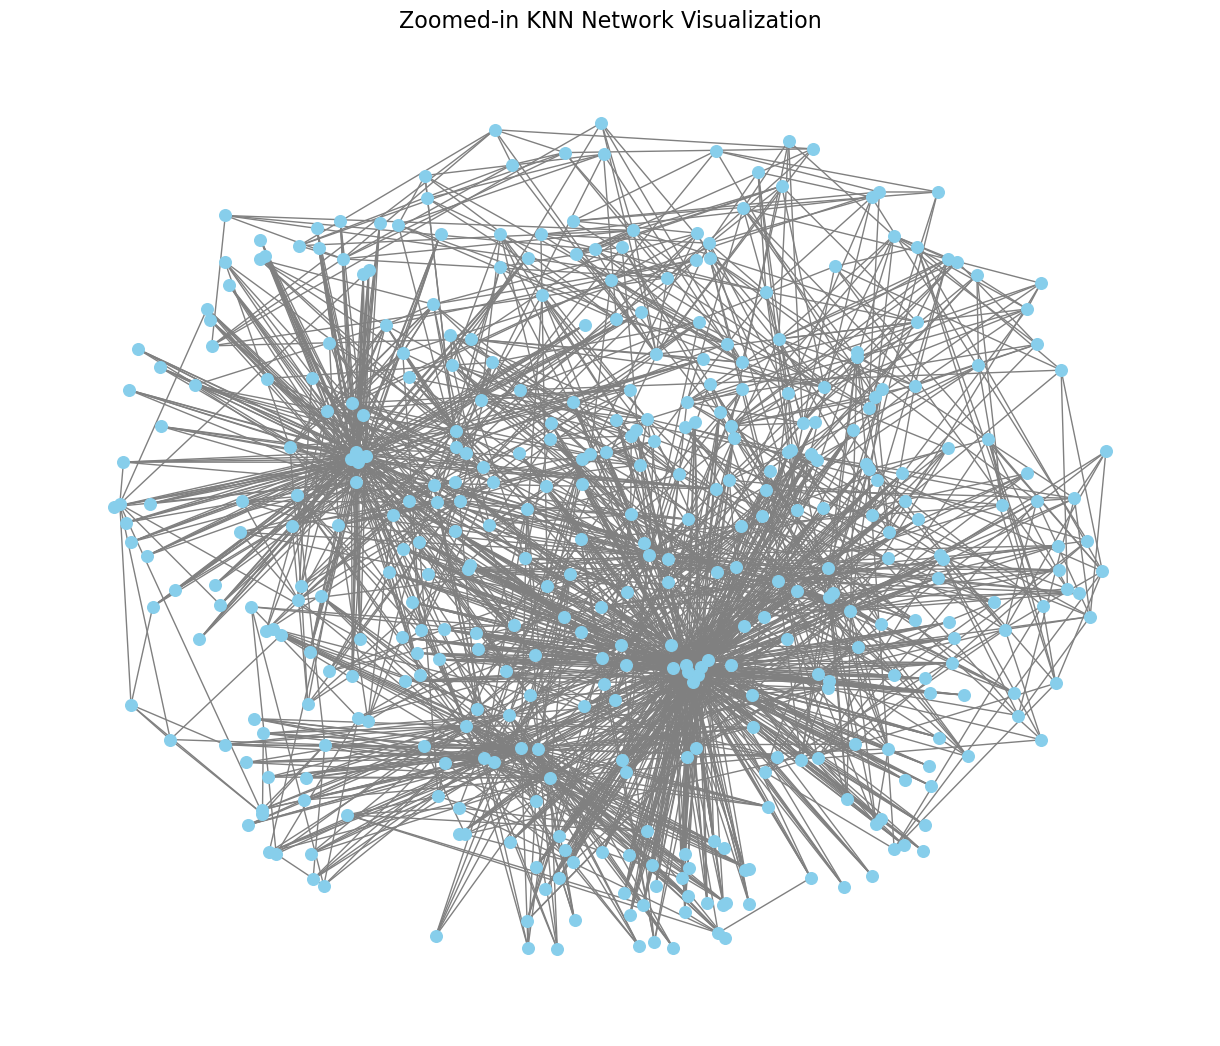

Network saved as knn_network_2.gml


In [140]:
visualize_and_save_knn_network(G_knn, output_filename="knn_network_2.gml", zoom_factor=0.5)

In [6]:
def detect_communities(G):
    """
    Detect communities in a network using Louvain modularity maximization.

    Parameters:
        G: NetworkX Graph object.

    Returns:
        Dictionary mapping nodes to their community ID.
    """
    communities = modularity_max.greedy_modularity_communities(G)
    community_mapping = {}
    for community_id, community_nodes in enumerate(communities):
        for node in community_nodes:
            community_mapping[node] = community_id
    return community_mapping


In [201]:
community_mapping = detect_communities(G_knn)

In [32]:
def analyze_community(G, community_dict, community_id):
    # Get nodes in the community
    community_nodes = [node for node, comm_id in community_dict.items() if comm_id == community_id]
    
    # Create subgraph for the community
    subgraph = G.subgraph(community_nodes)
    
    # Check for disconnected components
    components = list(nx.connected_components(subgraph))
    largest_component = max(components, key=len)  # Get the largest connected component
    subgraph = subgraph.subgraph(largest_component)  # Focus on the largest component
    
    # Calculate centrality measures
    degree_centrality = nx.degree_centrality(subgraph)
    closeness_centrality = nx.closeness_centrality(subgraph)
    betweenness_centrality = nx.betweenness_centrality(subgraph)
    
    # Handle eigenvector centrality with try-except to catch convergence issues
    try:
        eigenvector_centrality = nx.eigenvector_centrality(subgraph)
    except nx.PowerIterationFailedConvergence:
        print(f"Eigenvector centrality calculation failed for community {community_id}")
        eigenvector_centrality = {}  # Assign empty dictionary if failed
    
    # Calculate additional metrics
    clustering_coefficient = nx.clustering(subgraph)
    avg_path_length = nx.average_shortest_path_length(subgraph) if nx.is_connected(subgraph) else float('inf')
    
    # Print out the results
    print(f"Community {community_id} Analysis:")
    print("Degree Centrality:", degree_centrality)
    print("Closeness Centrality:", closeness_centrality)
    print("Betweenness Centrality:", betweenness_centrality)
    print("Eigenvector Centrality:", eigenvector_centrality)
    print("Clustering Coefficient:", clustering_coefficient)
    print(f"Average Path Length: {avg_path_length}")
    print("="*50)
    
    return {
        'degree_centrality': degree_centrality,
        'closeness_centrality': closeness_centrality,
        'betweenness_centrality': betweenness_centrality,
        'eigenvector_centrality': eigenvector_centrality,
        'clustering_coefficient': clustering_coefficient,
        'avg_path_length': avg_path_length
    }


In [30]:
def visualize_communities_and_analysis(G, community_mapping):
    """
    Visualize each community in the network along with its summarized analysis results displayed as a text box.

    Parameters:
        G: NetworkX graph
        community_mapping: Dictionary mapping nodes to their community IDs
    """
    # Extract unique communities
    communities = list(set(community_mapping.values()))
    num_communities = len(communities)
    
    # Set up the subplots: Adjust figsize for the number of communities
    fig, axes = plt.subplots(nrows=num_communities, ncols=1, figsize=(10, 5 * num_communities))

    # Ensure axes is always a list for consistent indexing
    if num_communities == 1:
        axes = [axes]
    
    # Loop through communities
    for idx, community in enumerate(communities):
        community_nodes = [node for node, comm in community_mapping.items() if comm == community]
        subgraph = G.subgraph(community_nodes)

        # Analysis function: Replace with your actual analysis or use this sample
        degree_centrality = nx.degree_centrality(subgraph)
        closeness_centrality = nx.closeness_centrality(subgraph)
        betweenness_centrality = nx.betweenness_centrality(subgraph)
        clustering_coefficient = nx.clustering(subgraph)

        avg_path_length = (
            nx.average_shortest_path_length(subgraph)
            if nx.is_connected(subgraph)
            else float('inf')
        )

        # Compute summaries for each metric
        def summarize_metric(metric):
            return {
                "mean": np.mean(list(metric.values())),
                "max": np.max(list(metric.values())),
                "min": np.min(list(metric.values())),
            }

        degree_summary = summarize_metric(degree_centrality)
        closeness_summary = summarize_metric(closeness_centrality)
        betweenness_summary = summarize_metric(betweenness_centrality)
        clustering_summary = summarize_metric(clustering_coefficient)

        # Plot the subgraph
        ax = axes[idx]
        pos = nx.spring_layout(subgraph)  # Change layout as needed
        nx.draw(
            subgraph, pos, ax=ax, with_labels=False, node_size=50, font_size=8,
            node_color='skyblue', edge_color='gray'
        )
        ax.set_title(f"Community {community} Visualization", fontsize=14)

        # Format analysis results into a readable string
        analysis_str = (
            f"Community {community} Analysis:\n"
            f"Degree Centrality (Mean/Max/Min): {degree_summary['mean']:.2f}/{degree_summary['max']:.2f}/{degree_summary['min']:.2f}\n"
            f"Closeness Centrality (Mean/Max/Min): {closeness_summary['mean']:.2f}/{closeness_summary['max']:.2f}/{closeness_summary['min']:.2f}\n"
            f"Betweenness Centrality (Mean/Max/Min): {betweenness_summary['mean']:.2f}/{betweenness_summary['max']:.2f}/{betweenness_summary['min']:.2f}\n"
            f"Clustering Coefficient (Mean/Max/Min): {clustering_summary['mean']:.2f}/{clustering_summary['max']:.2f}/{clustering_summary['min']:.2f}\n"
            f"Average Path Length: {avg_path_length:.2f}\n"
        )
        
        # Add the analysis text box to the plot
        ax.text(
            0.05, 0.95, analysis_str, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', horizontalalignment='left',
            bbox=dict(facecolor='white', alpha=0.7)
        )

    # Adjust layout
    plt.tight_layout()
    plt.show()


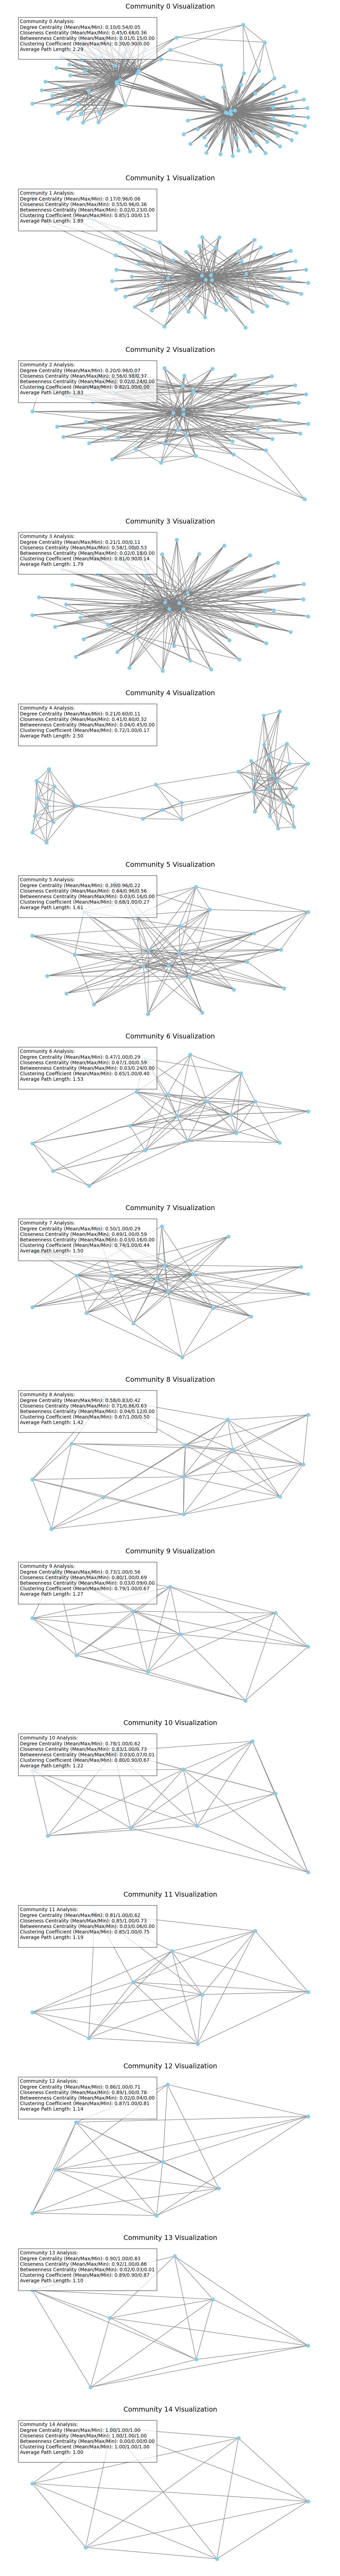

In [205]:
visualize_communities_and_analysis(G_knn, community_mapping)

In [191]:
def plot_network_on_map(G, community_dict, title="Ecological Network on Geographical Map"):
    """
    Plot an ecological network on a geographical map with nodes colored by community.
    
    Parameters:
        G: NetworkX graph with nodes containing latitude and longitude attributes
        community_dict: Dictionary with nodes as keys and community IDs as values
        title: Title of the map
    """
    # Create a Cartopy map using PlateCarree projection (lat-lon)
    fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_extent([-180, 180, -60, 90])  # Longitude and latitude bounds
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.COASTLINE, edgecolor='black')
    ax.add_feature(cfeature.BORDERS, edgecolor='black')
    ax.set_title(title, fontsize=16)

    # Assign random colors to communities
    community_colors = {community: (random.random(), random.random(), random.random())
                        for community in set(community_dict.values())}

    # Plot nodes
    for node in G.nodes:
        # Get latitude and longitude from node attributes
        lat = G.nodes[node]['latitude']
        lon = G.nodes[node]['longitude']
        community = community_dict[node]

        # Plot the node on the map
        ax.scatter(lon, lat, s=50, c=[community_colors[community]], edgecolor='black', zorder=5,
                   transform=ccrs.PlateCarree())

    # Plot edges
    for u, v in G.edges:
        # Get latitudes and longitudes of the nodes
        lat_u, lon_u = G.nodes[u]['latitude'], G.nodes[u]['longitude']
        lat_v, lon_v = G.nodes[v]['latitude'], G.nodes[v]['longitude']

        # Plot the edge as a line
        ax.plot([lon_u, lon_v], [lat_u, lat_v], color='gray', alpha=0.5, linewidth=0.5, zorder=4,
                transform=ccrs.PlateCarree())

    legend_labels = [f"Community {community}" for community in community_colors]
    legend_handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10)
                      for color in community_colors.values()]
    
    ax.legend(handles=legend_handles, labels=legend_labels, loc='upper left', title="Community Legend")


    # Show plot
    plt.show()


d:\App\python\Lib\site-packages\pyproj\transformer.py:817: UserWarning: Warning: converting a masked element to nan.
  return self._transformer._transform_point(
d:\App\python\Lib\site-packages\pyproj\transformer.py:817: UserWarning: Warning: converting a masked element to nan.
  return self._transformer._transform_point(
d:\App\python\Lib\site-packages\pyproj\transformer.py:817: UserWarning: Warning: converting a masked element to nan.
  return self._transformer._transform_point(
d:\App\python\Lib\site-packages\pyproj\transformer.py:817: UserWarning: Warning: converting a masked element to nan.
  return self._transformer._transform_point(
d:\App\python\Lib\site-packages\pyproj\transformer.py:817: UserWarning: Warning: converting a masked element to nan.
  return self._transformer._transform_point(
d:\App\python\Lib\site-packages\pyproj\transformer.py:817: UserWarning: Warning: converting a masked element to nan.
  return self._transformer._transform_point(
d:\App\python\Lib\site-packa

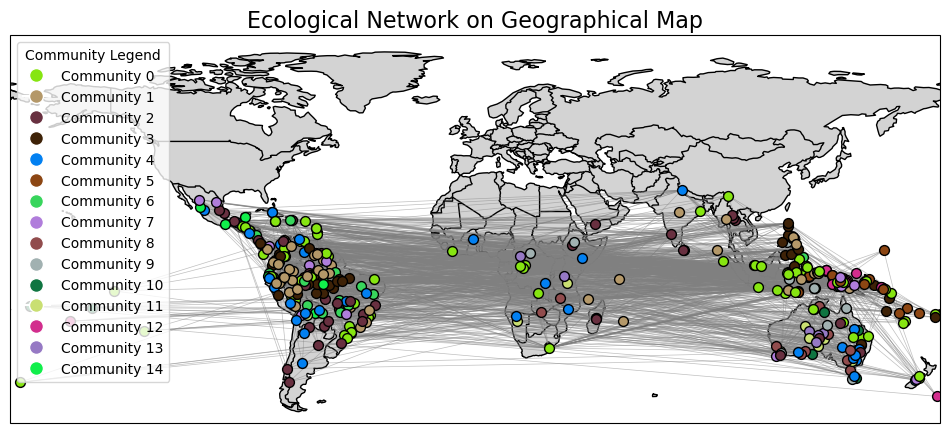

In [207]:
from matplotlib.lines import Line2D

plot_network_on_map(G_knn, community_mapping, title="Ecological Network on Geographical Map")

In [213]:
import networkx as nx
import json

def gml_to_json_custom(gml_path, json_path):
    """
    Convert GML to custom JSON format with separate node and edge lists.

    Parameters:
        gml_path (str): Path to the input GML file.
        json_path (str): Path to save the output JSON file.

    Returns:
        dict: Custom JSON representation of the graph.
    """
    # Read the GML file
    G = nx.read_gml(gml_path)

    # Create custom format
    graph_data = {
        'nodes': [],
        'edges': []
    }

    # Add nodes with attributes
    for node, attrs in G.nodes(data=True):
        node_data = {'id': node}
        node_data.update(attrs)  # Include all node attributes
        graph_data['nodes'].append(node_data)

    # Add edges with attributes
    for source, target, attrs in G.edges(data=True):
        edge_data = {
            'source': source,
            'target': target
        }
        edge_data.update(attrs)  # Include all edge attributes
        graph_data['edges'].append(edge_data)

    # Save to JSON file
    with open(json_path, 'w') as f:
        json.dump(graph_data, f, indent=2)

    # Print summary
    print(f"Graph converted to JSON: {json_path}")
    print(f"Number of Nodes: {len(graph_data['nodes'])}")
    print(f"Number of Edges: {len(graph_data['edges'])}")

    return graph_data


In [214]:
gml_path = "knn_network.gml"  # Path to the GML file created earlier
json_path = "knn_network.json"  # Desired path for the output JSON file

graph_data = gml_to_json_custom(gml_path, json_path)

Graph converted to JSON: knn_network.json
Number of Nodes: 399
Number of Edges: 1743


In [141]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Function to perform network analysis
def centrality_distribution(G):
    analysis_results = {}

    # 1. Degree Centrality
    degree_centrality = nx.degree_centrality(G)
    avg_degree_centrality = sum(degree_centrality.values()) / len(degree_centrality)
    analysis_results['Degree Centrality'] = avg_degree_centrality
    print(f"Average Degree Centrality for the network: {avg_degree_centrality}")

    # 2. Closeness Centrality
    closeness_centrality = nx.closeness_centrality(G)
    avg_closeness_centrality = sum(closeness_centrality.values()) / len(closeness_centrality)
    analysis_results['Closeness Centrality'] = avg_closeness_centrality
    print(f"Average Closeness Centrality for the network: {avg_closeness_centrality}")

    # 3. Betweenness Centrality
    betweenness_centrality = nx.betweenness_centrality(G)
    avg_betweenness_centrality = sum(betweenness_centrality.values()) / len(betweenness_centrality)
    analysis_results['Betweenness Centrality'] = avg_betweenness_centrality
    print(f"Average Betweenness Centrality for the network: {avg_betweenness_centrality}")

    # 4. Eigenvector Centrality
    try:
        eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=500)
    except nx.PowerIterationFailedConvergence:
        print("Warning: Power iteration failed to converge. Trying approximation...")
        eigenvector_centrality = nx.eigenvector_centrality_numpy(G)
    avg_eigenvector_centrality = sum(eigenvector_centrality.values()) / len(eigenvector_centrality)
    analysis_results['Eigenvector Centrality'] = avg_eigenvector_centrality
    print(f"Average Eigenvector Centrality for the network: {avg_eigenvector_centrality}")

    # Plot the distributions of centralities
    plot_centrality_distributions(G)
    
    return analysis_results

# Function to plot centrality distributions
def plot_centrality_distributions(G):
    # Calculate centralities
    degree_dic = nx.degree_centrality(G)
    betwns_dic = nx.betweenness_centrality(G)
    closen_dic = nx.closeness_centrality(G)
    
    try:
        eigenv_dic = nx.eigenvector_centrality(G, max_iter=500)
    except nx.PowerIterationFailedConvergence:
        print("Warning: Power iteration failed to converge. Trying approximation...")
        eigenv_dic = nx.eigenvector_centrality_numpy(G)
    
    # Convert to lists for plotting
    degree = list(degree_dic.values())
    betwns = list(betwns_dic.values())
    closen = list(closen_dic.values())
    eigenv = list(eigenv_dic.values())

    # Centrality names and titles for plotting
    centrality_titles = [
        ('degree', "Degree Centrality"),
        ('betweenness', "Betweenness Centrality"),
        ('closeness', "Closeness Centrality"),
        ('eigenvector', "Eigenvector Centrality")
    ]
    
    # Store centralities in a dictionary for easier access
    centralities = {
        'degree': degree,
        'betweenness': betwns,
        'closeness': closen,
        'eigenvector': eigenv
    }

    # Create a figure with 2x2 subplots for centrality distributions
    fig, axs = plt.subplots(2, 2, figsize=(10, 8), dpi=180)
    fig.suptitle(f'Centrality Distributions')

    # Loop through centralities and plot their distributions
    for ax, (centrality_key, centrality_title) in zip(axs.flatten(), centrality_titles):
        data = centralities[centrality_key]
        
        # Calculate the histogram
        counts, bins = np.histogram(data, bins=30)
        
        # Normalize the histogram
        normalized_counts = counts / sum(counts)

        # Plot the normalized frequency distribution as a bar chart
        ax.bar(bins[:-1], normalized_counts, width=np.diff(bins), align="edge", alpha=0.7)

        # Set labels and title for each subplot
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')
        ax.set_title(centrality_title)

        ax.set_xlim(0, 0.4)
        ax.set_ylim(0,)

        ax.grid(True, alpha=0.3)

    fig.tight_layout()
    plt.show()



In [7]:
import networkx as nx
from networkx.algorithms.community import modularity_max

def perform_assortativity_analysis(G, attributes):
    """
    Analyze assortativity of the network based on given node attributes and degree.

    Parameters:
    - G: NetworkX graph.
    - attributes: List of node attribute names to analyze assortativity.

    Returns:
    - assortativity_results: Dictionary with assortativity coefficients for each attribute and degree.
    """
    assortativity_results = {}

    # Calculate assortativity for each attribute
    for attribute in attributes:
        if all(attribute in G.nodes[node] for node in G.nodes):
            try:
                coeff = nx.attribute_assortativity_coefficient(G, attribute)
                assortativity_results[f"Assortativity ({attribute})"] = coeff
            except Exception as e:
                assortativity_results[f"Assortativity ({attribute})"] = f"Error: {e}"
        else:
            assortativity_results[f"Assortativity ({attribute})"] = "Attribute missing in some nodes"
    
    # Calculate degree assortativity
    try:
        degree_assortativity = nx.degree_assortativity_coefficient(G)
        assortativity_results["Degree Assortativity"] = degree_assortativity
    except Exception as e:
        assortativity_results["Degree Assortativity"] = f"Error: {e}"
    
    return assortativity_results

def perform_network_analysis(G, attributes):
    """
    Perform a comprehensive analysis of the network.

    Parameters:
    - G: NetworkX graph.
    - attributes: List of node attribute names to analyze assortativity.

    Returns:
    - analysis_results: Dictionary containing analysis results.
    """
    analysis_results = {}
    
    # 1. Clustering Coefficient
    clustering_coefficient = nx.clustering(G)
    avg_clustering_coefficient = sum(clustering_coefficient.values()) / len(clustering_coefficient)
    analysis_results['Clustering Coefficient'] = avg_clustering_coefficient
    print(f"Average Clustering Coefficient for the network: {avg_clustering_coefficient}")

    # 2. Average Path Length (Only for connected graphs)
    try:
        avg_path_length = nx.average_shortest_path_length(G)
        analysis_results['Average Path Length'] = avg_path_length
        print(f"Average Path Length for the network: {avg_path_length}")
    except nx.NetworkXError:
        print("Graph is not connected. Skipping average path length calculation.")

    # 3. Modularity (community detection)
    communities = modularity_max.greedy_modularity_communities(G)
    modularity = nx.community.modularity(G, communities)
    analysis_results['Modularity'] = modularity
    print(f"Modularity for the network: {modularity}")

    # 4. Assortativity (for given attributes)
    assortativity_results = perform_assortativity_analysis(G, attributes)
    analysis_results['Assortativity'] = assortativity_results
    print("Assortativity Analysis:")
    for key, value in assortativity_results.items():
        print(f"{key}: {value}")

    return analysis_results


In [8]:
import json
import networkx as nx


G_knn = nx.read_gml("D:\Downloads\Avonet\eco_network.gml")

Gr = nx.random_reference(G_knn, niter=100, connectivity=False, seed=1234)
# List of attributes for assortativity analysis
attributes = ['habitat', 'migration', 'trophic_level','trophic_niche', 'primary_lifestyle']


Average Degree Centrality for the network: 0.022002241785367853
Average Closeness Centrality for the network: 0.07575205849218054
Average Betweenness Centrality for the network: 0.0023146229306288506
Average Eigenvector Centrality for the network: 0.02095608889045162


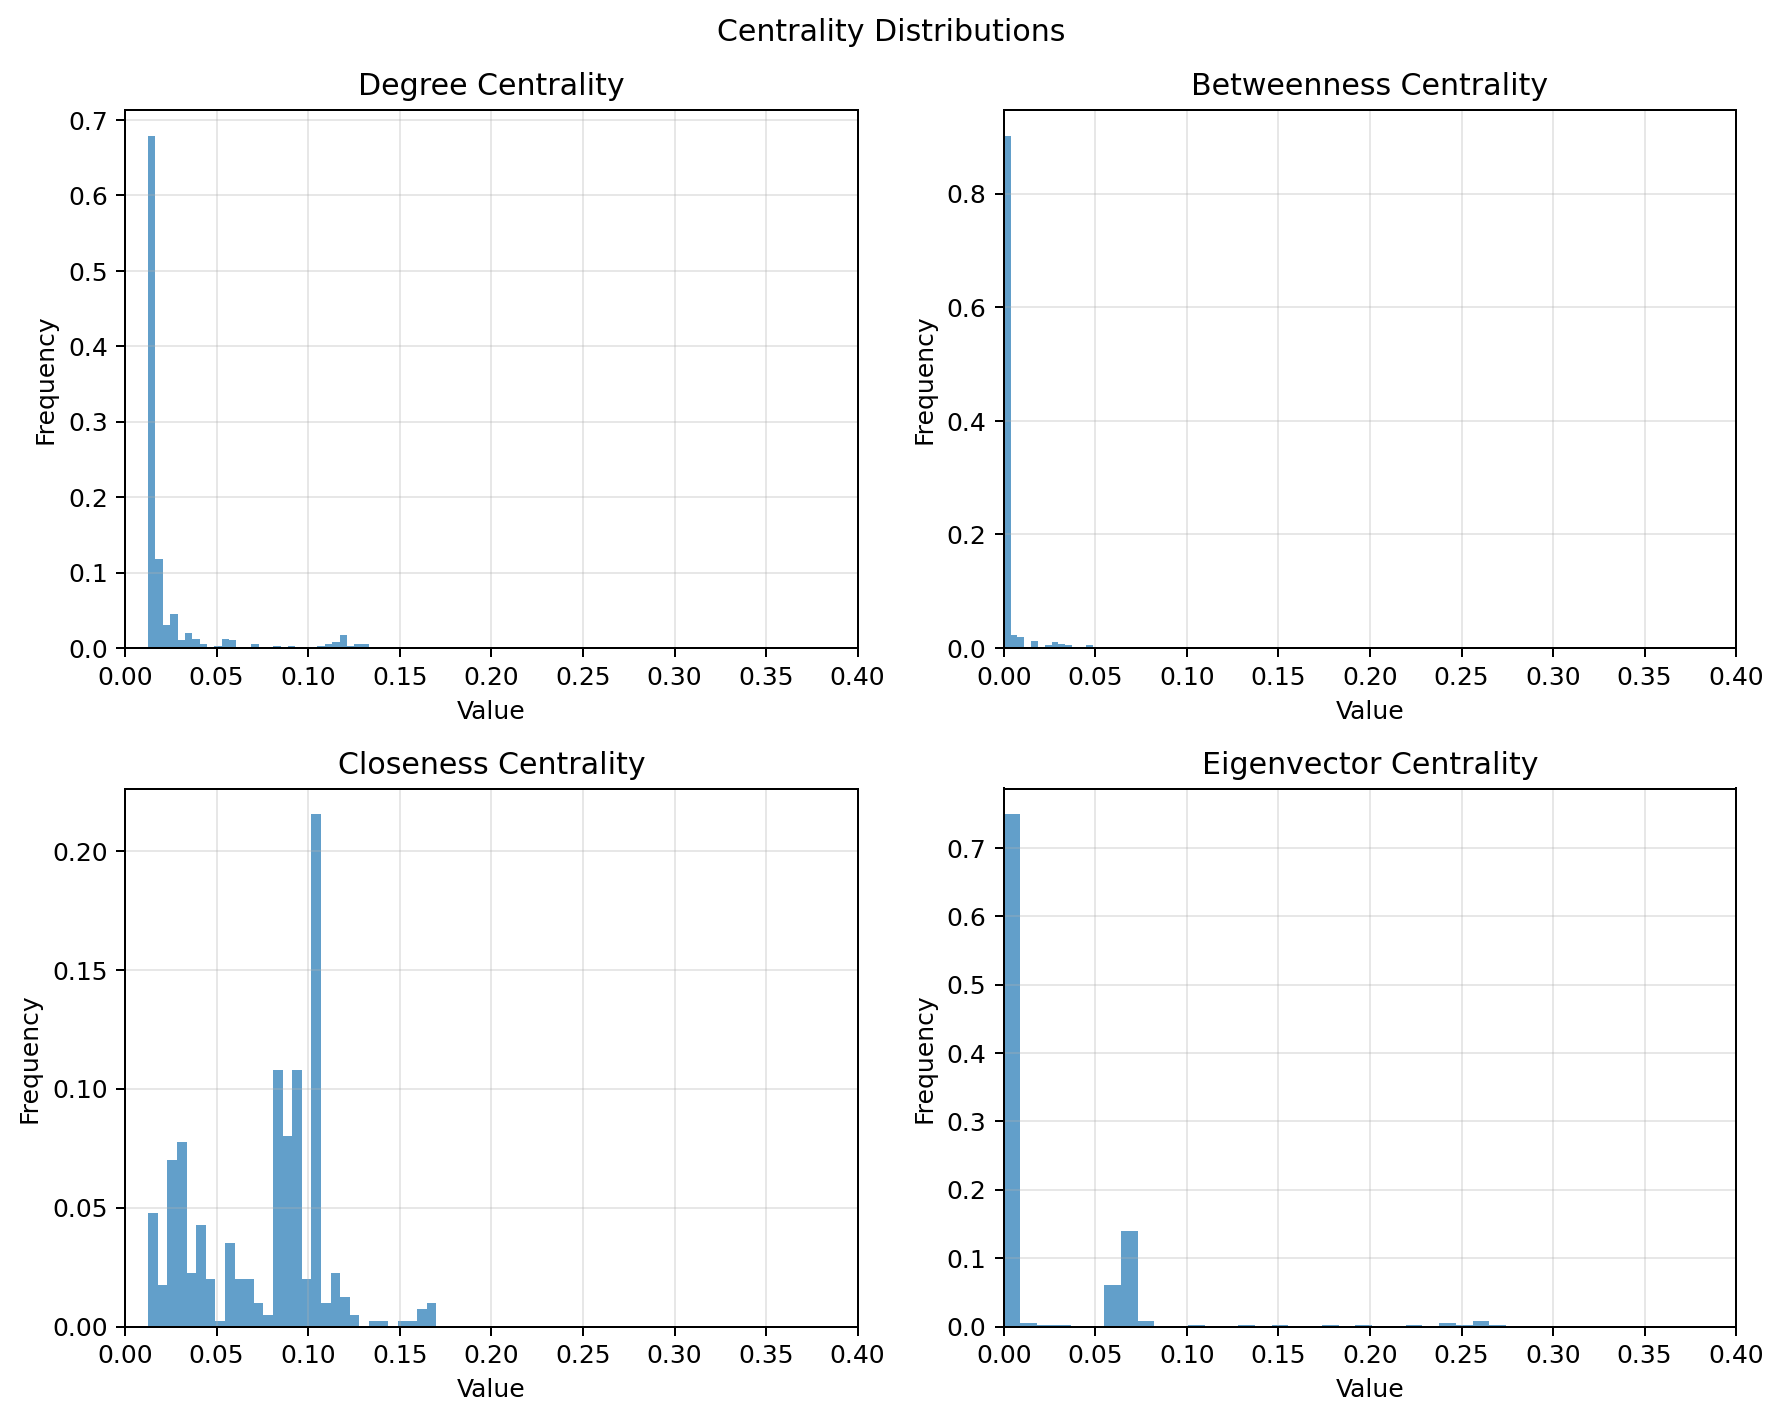

In [145]:
distribution_plotting = centrality_distribution(G_knn)

An average degree centrality of 0.022 means that, on average, each species (node) in the network is directly connected to only a small fraction (2.2%) of the total species in the network. This suggests the network has sparse connections, which could imply specialized relationships or a highly modular structure (where species primarily connect within their own communities).

An average closeness centrality of 0.076 indicates that the species in your network are not highly interconnected. This is typical for ecological networks with distinct community structures, where certain groups of species interact more within their communities than across the network

An average betweenness centrality of 0.0023 is quite low, meaning that most species in the network do not serve as critical connectors or "bridges." This reinforces the idea of a modular network structure, where connectivity is largely localized within communities, and only a few species (if any) act as links between communities.

If the eigenvector centrality is low, it suggests no species dominates in terms of connectivity, further supporting the modularity of the network.



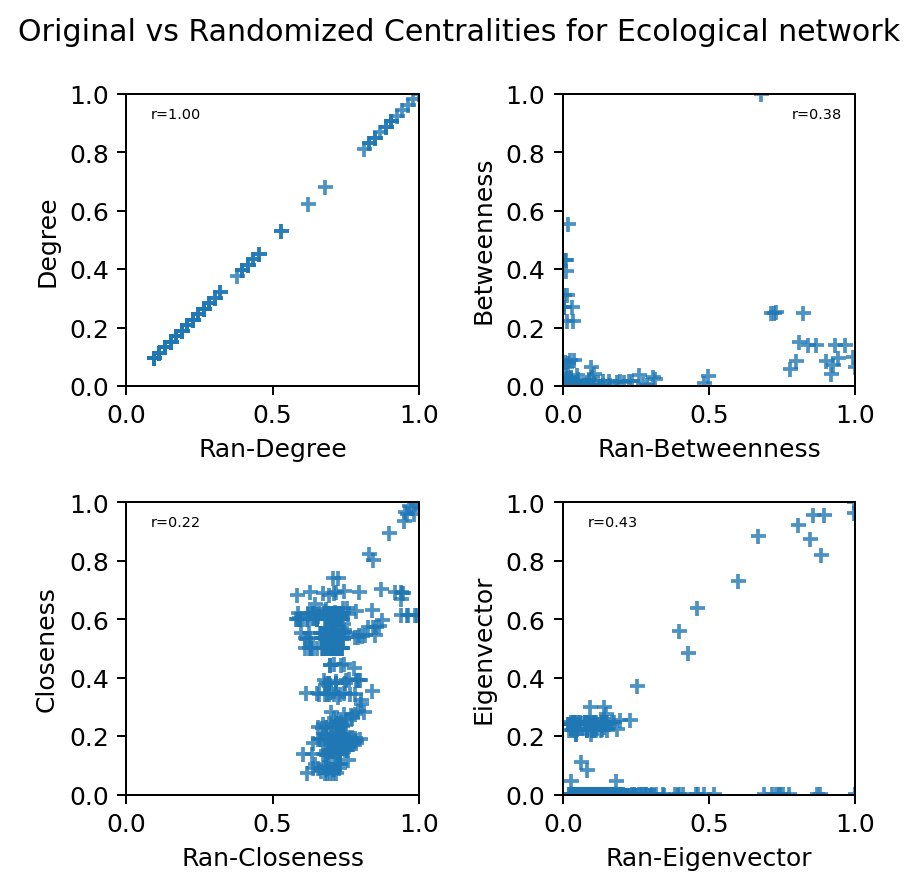

In [146]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import scipy as sp

def plot_centralities_comparison(network_file, network_label, seed=1234, niter=100):
    """
    Function to plot centrality comparisons between an original graph and its randomized version.
    
    Parameters:
    - network_file: Path to the network file (GML format).
    - network_label: Label for the network (used in plot titles).
    - seed: Random seed for reproducibility in graph randomization.
    - niter: Number of iterations for the random reference graph generation.
    """
    def calculate_centralities(graph):
        """
        Helper function to calculate centralities for a given graph.
        Returns degree, betweenness, closeness, and eigenvector centralities.
        """
        degree = dict(nx.degree_centrality(graph))
        betweenness = dict(nx.betweenness_centrality(graph))
        closeness = dict(nx.closeness_centrality(graph))
        eigenvector = dict(nx.eigenvector_centrality(graph, max_iter=1000))
        return degree, betweenness, closeness, eigenvector

    # Read the original graph
    G = nx.read_gml(network_file, label='id')

    # Generate the randomized version of the graph
    Gr = nx.random_reference(G, niter=niter, connectivity=False, seed=seed)

    # Calculate centralities for both original and randomized graphs
    degree, betwns, closen, eigenv = calculate_centralities(G)
    ran_degree, ran_betwns, ran_closen, ran_eigenv = calculate_centralities(Gr)

    # Centralities dictionary for original and randomized graphs
    centralities = {
        'degree': degree,
        'betweenness': betwns,
        'closeness': closen,
        'eigenvector': eigenv,
        'ran_degree': ran_degree,
        'ran_betweenness': ran_betwns,
        'ran_closeness': ran_closen,
        'ran_eigenvector': ran_eigenv
    }

    # Pairs for plotting
    randomized_pairs = [
        ('degree', 'ran_degree', 'Ran-Degree', 'Degree'),
        ('betweenness', 'ran_betweenness', 'Ran-Betweenness', 'Betweenness'),
        ('closeness', 'ran_closeness', 'Ran-Closeness', 'Closeness'),
        ('eigenvector', 'ran_eigenvector', 'Ran-Eigenvector', 'Eigenvector')
    ]

    # Create the plot
    fig, axs = plt.subplots(2, 2, figsize=(5, 5), dpi=180)
    fig.suptitle(f'Original vs Randomized Centralities for {network_label}')
    
    for ax, (original_key, random_key, labex, labey) in zip(axs.flatten(), randomized_pairs):
        # Get the original and randomized values
        original_values = np.array(list(centralities[original_key].values()))
        random_values = np.array(list(centralities[random_key].values()))

        # Normalize the values for plotting
        original_values = original_values / np.max(original_values)
        random_values = random_values / np.max(random_values)

        # Calculate Pearson correlation
        pea = sp.stats.pearsonr(random_values, original_values)[0]

        # Plot scatter plot
        ax.scatter(random_values, original_values, label=f"r={pea:.2f}", alpha=0.8, marker='+')
        
        # Set labels
        ax.set_xlabel(labex)
        ax.set_ylabel(labey)
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_aspect('equal')

        # Add legend
        ax.legend(loc='best', frameon=False, shadow=False, ncol=1,
                  fontsize='xx-small', handlelength=0, markerscale=0)
    
    fig.tight_layout()
    plt.show()

# Example call to the function
network_file = 'D:\Downloads\Avonet\eco_network.gml'  # Replace with the actual file path
network_label = 'Ecological network'  # Replace with a label for your network
plot_centralities_comparison(network_file, network_label)


In [9]:
network_analysis_results = perform_network_analysis(G_knn, attributes)
network_analysis_results_random = perform_network_analysis(Gr, attributes)


Average Clustering Coefficient for the network: 0.5746214762599154
Graph is not connected. Skipping average path length calculation.
Modularity for the network: 0.7985386232215149
Assortativity Analysis:
Assortativity (habitat): 0.9046021789215999
Assortativity (migration): 0.4203031724305166
Assortativity (trophic_level): -0.0014330753797337891
Assortativity (trophic_niche): 1.0
Assortativity (primary_lifestyle): 0.6031475820381159
Degree Assortativity: -0.36228230540312256
Average Clustering Coefficient for the network: 0.09712520258019956
Average Path Length for the network: 2.7650785254593773
Modularity for the network: 0.2920230575991093
Assortativity Analysis:
Assortativity (habitat): -0.035167845744340814
Assortativity (migration): -0.0033214323317964888
Assortativity (trophic_level): -0.0014330753797337891
Assortativity (trophic_niche): 0.005233469689570332
Assortativity (primary_lifestyle): 0.0030292914616093037
Degree Assortativity: -0.0678697069949124


Calculating best minimal value for power law fit


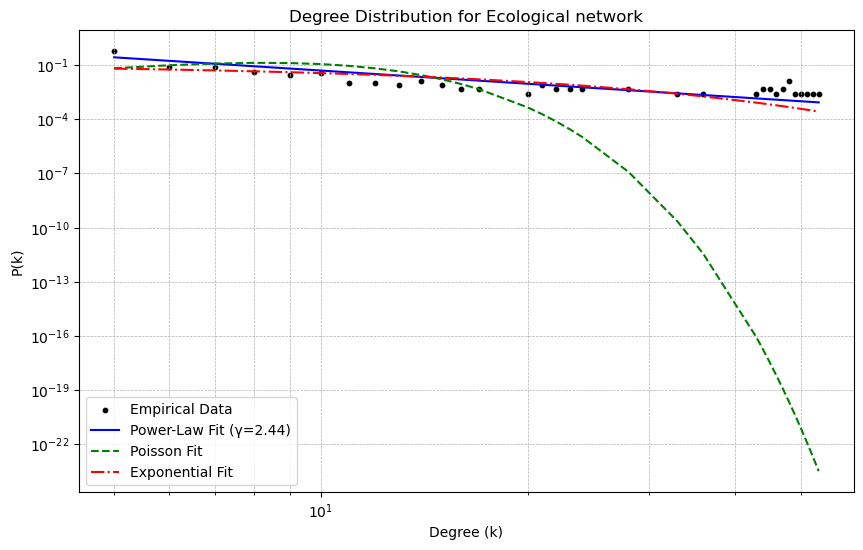

In [107]:
import networkx as nx
import powerlaw
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson

def plot_degree_distribution_with_fits(data_file, title_label=None):
    """
    Function to plot the degree distribution of a graph with power-law, Poisson, 
    and exponential fits.
    
    Parameters:
    - data_file: Path to the network file (GML format).
    - title_label: Optional title for the plot (default is derived from the file name).
    """
    # Load the graph
    G = nx.read_gml(data_file)

    # Calculate degree distribution
    degrees = np.array([d for n, d in G.degree()])
    degree_counts = np.bincount(degrees)
    k_values = np.arange(len(degree_counts))
    non_zero_k = k_values[degree_counts > 0]
    non_zero_counts = degree_counts[degree_counts > 0]

    # Fit a power-law distribution using the `powerlaw` package
    fit = powerlaw.Fit(degrees, discrete=True)
    alpha = fit.power_law.alpha  # power-law exponent

    # Mean degree ⟨k⟩ for Poisson and Exponential fits
    mean_k = np.mean(degrees)

    # Calculate the Poisson distribution with λ = ⟨k⟩
    poisson_dist = poisson.pmf(non_zero_k, mean_k)

    # Calculate the exponential distribution with λ = ⟨k⟩
    exp_dist = (1 / mean_k) * np.exp(-non_zero_k / mean_k)

    # Plot settings
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_title(title_label or f"Degree Distribution with Fits for {data_file.split('/')[-1]}")
    ax.set_xlabel("Degree (k)")
    ax.set_ylabel("P(k)")

    # Plot empirical degree distribution
    ax.scatter(non_zero_k, non_zero_counts / sum(non_zero_counts), color='black', label='Empirical Data', s=10)

    # Plot power-law fit
    powerlaw_fit = non_zero_k ** (-alpha)
    ax.plot(non_zero_k, powerlaw_fit / sum(powerlaw_fit), color='blue', linestyle='-', label=f'Power-Law Fit (γ={alpha:.2f})')

    # Plot Poisson fit
    ax.plot(non_zero_k, poisson_dist, color='green', linestyle='--', label='Poisson Fit')

    # Plot Exponential fit
    ax.plot(non_zero_k, exp_dist, color='red', linestyle='-.', label='Exponential Fit')

    # Add legend and grid
    ax.legend()
    plt.grid(True, which="both", linestyle='--', linewidth=0.5)
    plt.show()

# Example call to the function
data_file = 'D:\Downloads\Avonet\eco_network.gml'  # Replace with your actual file path
plot_degree_distribution_with_fits(data_file, title_label="Degree Distribution for Ecological network")


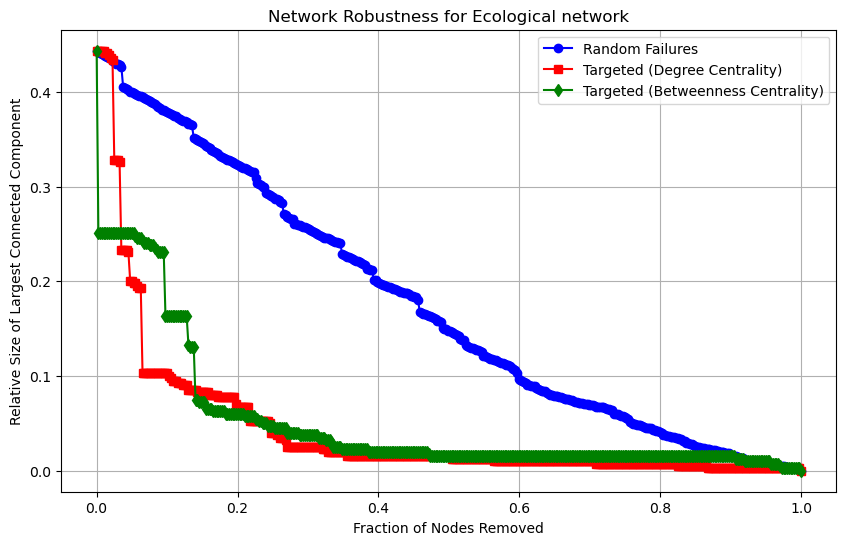

In [108]:
import networkx as nx
import matplotlib.pyplot as plt
import random

def load_network(path):
    return nx.read_gml(path)

def simulate_attack(graph, attack_type="random", centrality=None, iterations=1):
    n = len(graph)
    sizes = []

    if attack_type == "random":
        for _ in range(iterations):
            g = graph.copy()
            nodes = list(g.nodes())
            random.shuffle(nodes)
            lcc_sizes = [len(max(nx.connected_components(g), key=len)) / n]
            for i in range(len(nodes)):
                g.remove_node(nodes[i])
                if len(g) > 0:
                    lcc_sizes.append(len(max(nx.connected_components(g), key=len)) / n)
                else:
                    lcc_sizes.append(0)
            sizes.append(lcc_sizes)
        sizes = [sum(x) / iterations for x in zip(*sizes)]
    
    else:
        sorted_nodes = sorted(centrality, key=centrality.get, reverse=True)
        g = graph.copy()
        lcc_sizes = [len(max(nx.connected_components(g), key=len)) / n]
        for i in range(len(sorted_nodes)):
            g.remove_node(sorted_nodes[i])
            if len(g) > 0:
                lcc_sizes.append(len(max(nx.connected_components(g), key=len)) / n)
            else:
                lcc_sizes.append(0)
        sizes = lcc_sizes
    
    return sizes

def plot_attack_results(fractions, sizes_random, sizes_degree, sizes_betweenness, title):
    plt.figure(figsize=(10, 6))
    plt.plot(fractions, sizes_random, 'o-', color='blue', label='Random Failures')
    plt.plot(fractions, sizes_degree, 's-', color='red', label='Targeted (Degree Centrality)')
    plt.plot(fractions, sizes_betweenness, 'd-', color='green', label='Targeted (Betweenness Centrality)')
    plt.xlabel("Fraction of Nodes Removed")
    plt.ylabel("Relative Size of Largest Connected Component")
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

def analyze_network_robustness(network_path, title):
    """
    Analyze the robustness of a single network under random failures
    and targeted attacks based on degree and betweenness centralities.
    
    Parameters:
    - network_path: Path to the GML file of the network.
    - title: Title for the plot.
    """
    # Load the network
    graph = load_network(network_path)

    # Define the fractions of nodes removed for plotting
    fractions = [i / len(graph) for i in range(len(graph) + 1)]

    # Random failures
    sizes_random = simulate_attack(graph, attack_type="random", iterations=10)

    # Targeted attacks based on degree centrality
    degree_centrality = nx.degree_centrality(graph)
    sizes_degree = simulate_attack(graph, attack_type="degree", centrality=degree_centrality)

    # Targeted attacks based on betweenness centrality
    betweenness_centrality = nx.betweenness_centrality(graph)
    sizes_betweenness = simulate_attack(graph, attack_type="betweenness", centrality=betweenness_centrality)

    # Plot results
    plot_attack_results(fractions, sizes_random, sizes_degree, sizes_betweenness, title)

# Example usage
network_path = "D:\Downloads\Avonet\eco_network.gml"  # Replace with your actual file path
analyze_network_robustness(network_path, title="Network Robustness for Ecological network")
